In [1]:
# !pip install --upgrade pip

In [2]:
# !pip install fastparquet

In [3]:
# !pip install pathvalidate

In [4]:
# !pip install plot_keras_history

In [5]:
import pandas as pd
import numpy as np

import tensorflow as tf
import os
import shutil
import time
from pathvalidate import sanitize_filename
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from plot_keras_history import show_history, plot_history

import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
batch_size = 32

# Préparation des données

On commence par préparer le dossier d'images. En effet, toutes les images sont mélangées dans le même dossier, or la fonction que nous allons utiliser 
tf.keras.utils.image_dataset_from_directory s'attend à un sous-répertoire par catégorie

In [7]:
df = pd.read_csv("df_clean.csv")


In [8]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category0,cleaned_product_name,cleaned_description
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,polyest multicolor abstract eyelet door curtain,polyest multicolor abstract eyelet door curtai...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby care,cotton bath towel,cotton bath towel bath towel yellow blue bath ...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby care,cotton terri face towel,cotton terri face towel small cotton terri fac...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,cotton king doubl bedsheet,cotton king doubl bedsheet royal bedsheet perf...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing,cotton floral king doubl bedsheet,cotton floral king doubl bedsheet cotton cotto...


In [9]:
def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
        path, labels='inferred', label_mode='categorical',
        class_names=None, batch_size=batch_size, image_size=(299,299), shuffle=True,
        validation_split=validation_split, subset=data_type, seed=42
    )
    return dataset

In [10]:
path2 = "C:/Users/pouri/OneDrive/Bureau/P6/7categ1/train"
path3 = "C:/Users/pouri/OneDrive/Bureau/P6/7categ1/test"

In [11]:
dataset_train = dataset_fct(path2, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path2, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path3, validation_split=0, data_type=None)


Found 892 files belonging to 7 classes.
Using 669 files for training.
Found 892 files belonging to 7 classes.
Using 223 files for validation.
Found 158 files belonging to 7 classes.


# Création du modèle

In [12]:
def create_model() :
    # Data augmentation : les fonctions de data augmentations ne sont actives que durant les fit
    data_augmentation = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip("horizontal", input_shape=(299, 299, 3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
      ])
    
    # Récupération modèle pré-entraîné
    model_base = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = tf.keras.models.Sequential([
        data_augmentation,
        tf.keras.layers.Lambda(tf.keras.applications.inception_resnet_v2.preprocess_input, input_shape=(299, 299, 3)),
        tf.keras.layers.Rescaling(1./127.5, offset=-1),
        model_base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    return model


In [13]:
model = create_model()

In [14]:
model_save_path = "./model_best_weights_inceptionresnet.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_save_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

# Entrainement

In [15]:
t0 = time.time()
history = model.fit(dataset_train,
          validation_data=dataset_val,
          batch_size=32, epochs=100, callbacks=[checkpoint_cb, earlystopping_cb], verbose=1)
print(f"Durée de l'entrainement: {time.time() - t0}")

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 2.0648 - accuracy: 0.1839
Epoch 1: val_loss improved from inf to 1.91985, saving model to .\model_best_weights_inceptionresnet.h5
21/21 [==============================] - 100s 4s/step - loss: 2.0648 - accuracy: 0.1839 - val_loss: 1.9199 - val_accuracy: 0.2332
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 1.8722 - accuracy: 0.2511
Epoch 2: val_loss improved from 1.91985 to 1.76299, saving model to .\model_best_weights_inceptionresnet.h5
21/21 [==============================] - 90s 4s/step - loss: 1.8722 - accuracy: 0.2511 - val_loss: 1.7630 - val_accuracy: 0.2915
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 1.7795 - accuracy: 0.3109
Epoch 3: val_loss did not improve from 1.76299
21/21 [==============================] - 88s 4s/step - loss: 1.7795 - accuracy: 0.3109 - val_loss: 1.7674 - val_accuracy: 0.2915
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss:

21/21 [==============================] - 89s 4s/step - loss: 1.5129 - accuracy: 0.4425 - val_loss: 1.4896 - val_accuracy: 0.4798
Epoch 20/100
21/21 [==============================] - ETA: 0s - loss: 1.4814 - accuracy: 0.4439
Epoch 20: val_loss did not improve from 1.48956
21/21 [==============================] - 89s 4s/step - loss: 1.4814 - accuracy: 0.4439 - val_loss: 1.4944 - val_accuracy: 0.4350
Epoch 21/100
21/21 [==============================] - ETA: 0s - loss: 1.4629 - accuracy: 0.4439
Epoch 21: val_loss improved from 1.48956 to 1.45322, saving model to .\model_best_weights_inceptionresnet.h5
21/21 [==============================] - 88s 4s/step - loss: 1.4629 - accuracy: 0.4439 - val_loss: 1.4532 - val_accuracy: 0.4798
Epoch 22/100
21/21 [==============================] - ETA: 0s - loss: 1.4198 - accuracy: 0.4709
Epoch 22: val_loss did not improve from 1.45322
21/21 [==============================] - 89s 4s/step - loss: 1.4198 - accuracy: 0.4709 - val_loss: 1.4648 - val_accuracy

Epoch 48/100
21/21 [==============================] - ETA: 0s - loss: 1.2345 - accuracy: 0.5247
Epoch 48: val_loss did not improve from 1.41348
21/21 [==============================] - 91s 4s/step - loss: 1.2345 - accuracy: 0.5247 - val_loss: 1.4886 - val_accuracy: 0.4395
Epoch 49/100
21/21 [==============================] - ETA: 0s - loss: 1.2253 - accuracy: 0.5351
Epoch 49: val_loss did not improve from 1.41348
21/21 [==============================] - 94s 5s/step - loss: 1.2253 - accuracy: 0.5351 - val_loss: 1.4263 - val_accuracy: 0.4933
Epoch 50/100
21/21 [==============================] - ETA: 0s - loss: 1.2359 - accuracy: 0.5351
Epoch 50: val_loss did not improve from 1.41348
21/21 [==============================] - 93s 4s/step - loss: 1.2359 - accuracy: 0.5351 - val_loss: 1.4887 - val_accuracy: 0.4484
Epoch 51/100
21/21 [==============================] - ETA: 0s - loss: 1.3052 - accuracy: 0.5142
Epoch 51: val_loss did not improve from 1.41348
21/21 [==============================

# Evaluation

In [16]:
loss, accuracy = model.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

21/21 [==============================] - 65s 3s/step - loss: 1.1111 - accuracy: 0.6143
Training Accuracy   : 0.6143

7/7 [==============================] - 22s 3s/step - loss: 1.4211 - accuracy: 0.4753
Validation Accuracy :  0.4753


In [17]:
# Score de l'epoch optimal

model.load_weights(model_save_path)

loss, accuracy = model.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation Loss     :  {:.4f}".format(loss))


Validation Accuracy :  0.4843
Validation Loss     :  1.4002


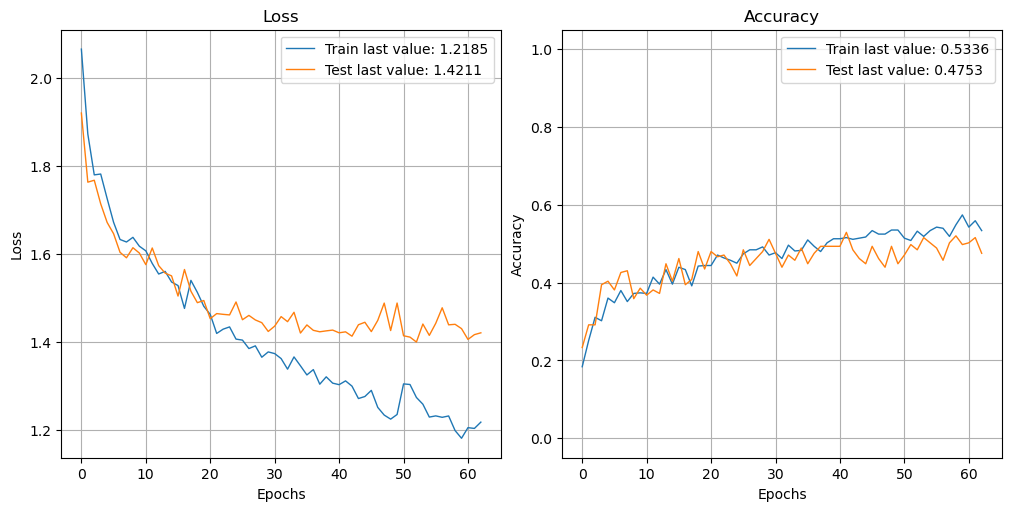

In [18]:
show_history(history)
plot_history(history, path="standard.png")
plt.close()

Calculons sur l'ensemble de test

In [19]:
loss, accuracy = model.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test Loss           :  {:.4f}".format(loss))

Test Accuracy       :  0.4747
Test Loss           :  1.5255


# Conclusion

In [20]:
dataset_test.class_names

['baby care',
 'beauty and personal care',
 'computers',
 'home decor & festive needs',
 'home furnishing',
 'kitchen & dining',
 'watches']

In [21]:
path3

'C:/Users/pouri/OneDrive/Bureau/P6/7categ1/test'

In [22]:
files = os.listdir(path3)
files

['baby care',
 'beauty and personal care',
 'computers',
 'home decor & festive needs',
 'home furnishing',
 'kitchen & dining',
 'watches']

In [23]:
files = os.listdir(path3 + '/Computers')
files

['00e966a5049a262cfc72e6bbf68b80e7.jpg',
 '26989e846c2096a5b59b59cbea2cc7ab.jpg',
 '28e3f1e490cfc4b47bfb50671ff93283.jpg',
 '291d5ff1e50dac3058cf10578f692085.jpg',
 '41dccf212ff447cd7213a2b1e669e406.jpg',
 '54754ccd18f2a75c53de68806176392a.jpg',
 '568f331e1039bf2e0635b899c2b3248f.jpg',
 '5a54c78b52c984e56500809e5bc27ae1.jpg',
 '6057d1b6682ab473a3fe2ca8b4577259.jpg',
 '6c3768639e82ceaeab681e083b897672.jpg',
 '7e6ae1b372e8e0b509b83ba3658b8107.jpg',
 '8e961e4fd248c9496ca54808d2d2b25f.jpg',
 '964648862f322b2cc153239af04b22ef.jpg',
 '9f141b3c3d9096f5a897d01b48e3b360.jpg',
 '9fb8662af03c957ade34d4c816d4e903.jpg',
 'a41371b2f8859b015031f0d5eda5184c.jpg',
 'a76bf8400b3dbcdbe5a5678f4a8ea0f6.jpg',
 'e426290a8f57e82680275bb91df91ad1.jpg',
 'e86daf9ebcdfc5c5dd088cdb7f8f8db6.jpg',
 'e8ee7868b0c3d1d04b482cd4f3ec5ccc.jpg',
 'ea199e645da893f2ab0c45cf07face13.jpg',
 'eeecf5d16fa6591290706f1fd0c6fc6e.jpg',
 'fc009e0b404034e5ea065ba980917f33.jpg']

In [24]:
df_test_com = df[df['image'].isin(files)]
df_test_com.head(1)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category0,cleaned_product_name,cleaned_description
54,7e6ae1b372e8e0b509b83ba3658b8107,2016-06-17 11:45:06 +0000,http://www.flipkart.com/jrb-1033-smallest-mobi...,JRB 1033 Smallest Mobile Powered By OTG Enable...,"[""Computers >> Laptop Accessories >> USB Gadge...",USGEJPQHFM7CVCYH,499.0,249.0,7e6ae1b372e8e0b509b83ba3658b8107.jpg,False,Key Features of JRB 1033 Smallest Mobile Power...,No rating available,No rating available,JRB,"{""product_specification""=>nil}",computers,smallest mobil power enabl android smart phone...,smallest mobil power enabl android smart phone...


In [25]:
my_image = tf.keras.preprocessing.image.load_img(path3 +'/computers/26989e846c2096a5b59b59cbea2cc7ab.jpg', target_size=(299, 299))
my_image = tf.keras.preprocessing.image.img_to_array(my_image)
print(my_image.shape)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
prediction = model.predict(my_image)
 

(299, 299, 3)
1/1 [==============================] - 4s 4s/step


In [26]:
dataset_test.class_names[prediction.argmax(axis=-1)[0]]

'baby care'

In [27]:
all_test_files = os.listdir('C:/Users/pouri/OneDrive/Bureau/P6/7categ1/test2')
all_test_files

['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg',
 '020d2daba55a723128e4e07c0b0393a9.jpg',
 '093097cfe5626f4ad8914e0a16a940b5.jpg',
 '0abfcbe0e17dd50c4cf5fb1d6037d514.jpg',
 '0c70a580d96e50966130e2885d8c3505.jpg',
 '0d3e1dc0d38be59e9927e47f152e48aa.jpg',
 '0dc4d2767fe8424a3263ab141884f83d.jpg',
 '112a8a56ee40ee31ea06fb7ff23b5c25.jpg',
 '142994b421c052a6193052c6c8c3d076.jpg',
 '14bc693d9b86c58696e5917045e9d4de.jpg',
 '1738ddb8f47f11ff0cb96fe6cad302c2.jpg',
 '184ecf07ca4e2872eaf53d2344a1e783.jpg',
 '1971dcd2f3058a4c87bdd7d87d4baeba.jpg',
 '2110699b945ae766c8b8112038ac58b9.jpg',
 '219b24362655097cb41bf06a0be8ee79.jpg',
 '24e85c590481a7cedfe66597f253f2b2.jpg',
 '26269fd0df12630eec4508c2cf3c94e1.jpg',
 '26989e846c2096a5b59b59cbea2cc7ab.jpg',
 '27b7851ae3dfc2ae8c1958cebe93bf0b.jpg',
 '28e3f1e490cfc4b47bfb50671ff93283.jpg',
 '291d5ff1e50dac3058cf10578f692085.jpg',
 '29b1ca231e10d5269516b80bf9d0dffc.jpg',
 '2abb35d6affd27

In [28]:
df_test = df[df['image'].isin(all_test_files)]
df_test.shape

(158, 18)

In [29]:
df_comp = pd.DataFrame(columns=["uniq_id", "category", "predicted"])
for uniq_id, category in df_test.loc[:, ["uniq_id", "category0"]].values:
    my_image = tf.keras.preprocessing.image.load_img(f'C:/Users/pouri/OneDrive/Bureau/P6/7categ1/test/{sanitize_filename(category)}/{uniq_id}.jpg', target_size=(299, 299))
    my_image = tf.keras.preprocessing.image.img_to_array(my_image)
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    prediction = model.predict(my_image, verbose=0)
    predicted = dataset_test.class_names[prediction.argmax(axis=-1)[0]]
    df_comp = pd.concat([df_comp, pd.DataFrame({"uniq_id": uniq_id, "category": category, "predicted": predicted}, index=[0])]).reset_index(drop=True)

In [30]:
df_comp

,uniq_id,category,predicted
0,d4684dcdc759dd9cdf41504698d737d8,home furnishing,computers
1,6325b6870c54cd47be6ebfbffa620ec7,home furnishing,baby care
2,41384da51732c0b4df3de8f395714fbb,watches,watches
3,920154acbe49d3202ed7d2ed2df1ea13,watches,kitchen & dining
4,3c74db45cbfc14a78b8466dca494b3bb,watches,watches
...,...,...,...
153,31ac1b66cc6bb396c83f124317589f8c,baby care,baby care
154,0c70a580d96e50966130e2885d8c3505,kitchen & dining,home decor & festive needs
155,eeecf5d16fa6591290706f1fd0c6fc6e,computers,computers
156,6057d1b6682ab473a3fe2ca8b4577259,computers,computers


## Matrice de confusion

In [31]:
conf_mat = confusion_matrix(df_comp["category"], df_comp["predicted"])
conf_mat

array([[12,  1,  1,  3,  2,  3,  0],
       [ 5, 14,  0,  2,  1,  0,  0],
       [ 5,  0, 14,  1,  0,  3,  0],
       [ 9,  3,  3,  5,  1,  1,  1],
       [10,  1,  3,  0,  6,  1,  1],
       [ 2,  1,  1,  5,  0, 14,  0],
       [ 4,  2,  0,  3,  0,  2, 12]], dtype=int64)

<Axes: >

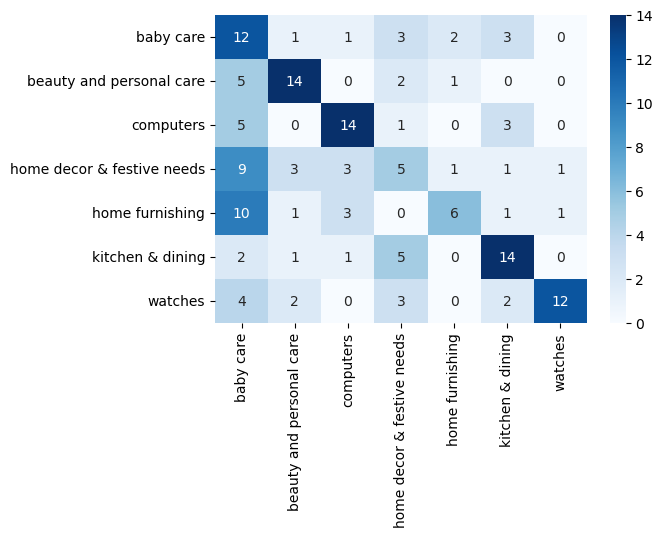

In [32]:
df_cm = pd.DataFrame(conf_mat, index = dataset_test.class_names,
                  columns = dataset_test.class_names)

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Score de classification

In [33]:
print(classification_report(df_comp["category"], df_comp["predicted"]))

                            precision    recall  f1-score   support

                 baby care       0.26      0.55      0.35        22
  beauty and personal care       0.64      0.64      0.64        22
                 computers       0.64      0.61      0.62        23
home decor & festive needs       0.26      0.22      0.24        23
           home furnishing       0.60      0.27      0.37        22
          kitchen & dining       0.58      0.61      0.60        23
                   watches       0.86      0.52      0.65        23

                  accuracy                           0.49       158
                 macro avg       0.55      0.49      0.49       158
              weighted avg       0.55      0.49      0.50       158



Nous avons ici un score F1 global de 51%.

## Analyse des erreurs



In [34]:
df_comp.loc[(df_comp["category"]=="beauty and personal care") & (df_comp["predicted"]!="beauty and personal care")]

,uniq_id,category,predicted
9,24e85c590481a7cedfe66597f253f2b2,beauty and personal care,home furnishing
12,0abfcbe0e17dd50c4cf5fb1d6037d514,beauty and personal care,baby care
13,1971dcd2f3058a4c87bdd7d87d4baeba,beauty and personal care,baby care
67,4e09d5a71d46d61de3d4c9c5aedb73f2,beauty and personal care,baby care
112,2abb35d6affd2796e664349a747bd302,beauty and personal care,baby care
118,020d2daba55a723128e4e07c0b0393a9,beauty and personal care,baby care
130,a11773bc4188f1c6226b941ec61c2024,beauty and personal care,home decor & festive needs
135,456ec612b30d4b091639843cdb66bf54,beauty and personal care,home decor & festive needs


24e85c590481a7cedfe66597f253f2b2 : Prédit "home furnishing" au lieu de "beauty and personal care" 


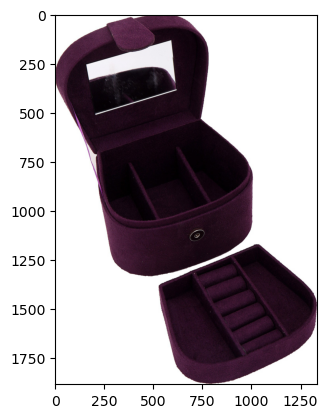

0abfcbe0e17dd50c4cf5fb1d6037d514 : Prédit "baby care" au lieu de "beauty and personal care" 


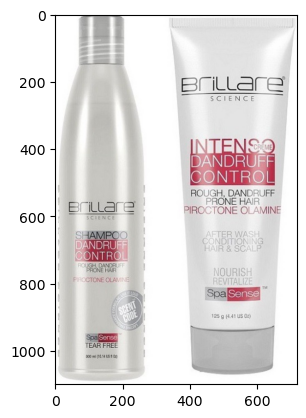

1971dcd2f3058a4c87bdd7d87d4baeba : Prédit "baby care" au lieu de "beauty and personal care" 


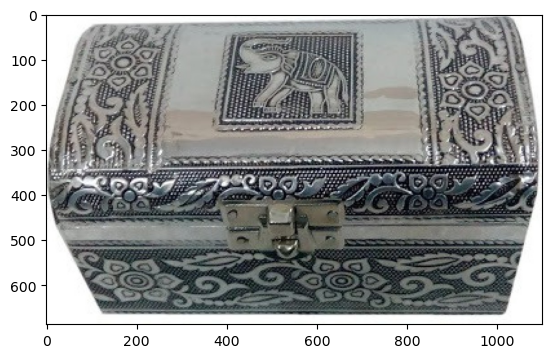

4e09d5a71d46d61de3d4c9c5aedb73f2 : Prédit "baby care" au lieu de "beauty and personal care" 


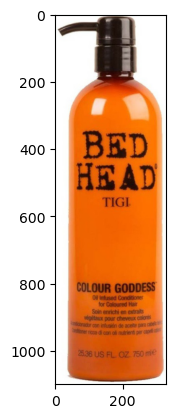

2abb35d6affd2796e664349a747bd302 : Prédit "baby care" au lieu de "beauty and personal care" 


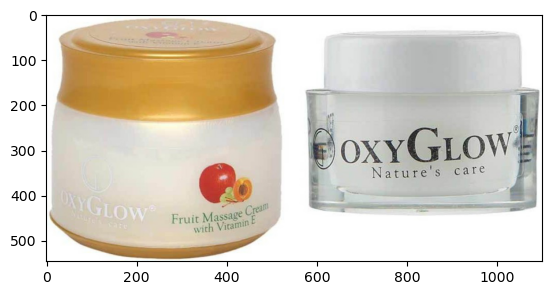

020d2daba55a723128e4e07c0b0393a9 : Prédit "baby care" au lieu de "beauty and personal care" 


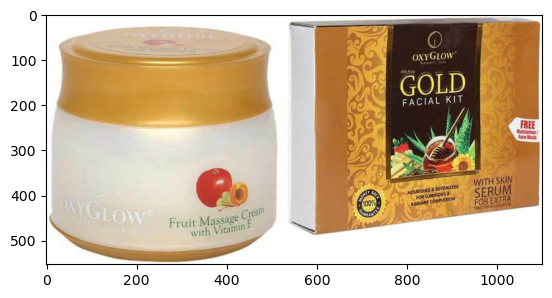

a11773bc4188f1c6226b941ec61c2024 : Prédit "home decor & festive needs" au lieu de "beauty and personal care" 


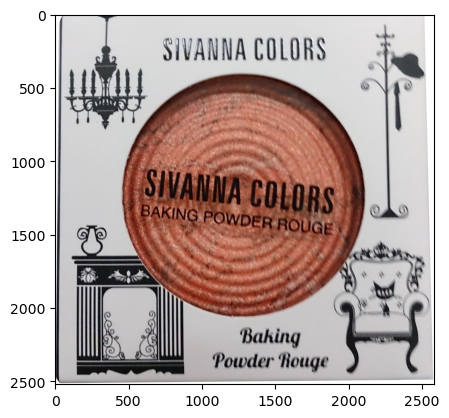

456ec612b30d4b091639843cdb66bf54 : Prédit "home decor & festive needs" au lieu de "beauty and personal care" 


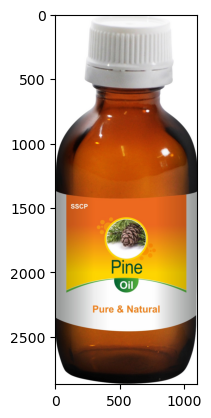

In [35]:

for uniq_id, category, predicted in df_comp.loc[(df_comp["category"]=="beauty and personal care") & (df_comp["predicted"]!="beauty and personal care"), ["uniq_id", "category", "predicted"]].values:
    print(f"""{uniq_id} : Prédit "{predicted}" au lieu de "{category}" """)
    img = plt.imread(f'C:/Users/pouri/OneDrive/Bureau/P6/7categ1/test/{sanitize_filename(category)}/{uniq_id}.jpg')
    imgplot = plt.imshow(img)
    plt.show()

7e6ae1b372e8e0b509b83ba3658b8107 : Prédit "baby care" au lieu de "computers" 


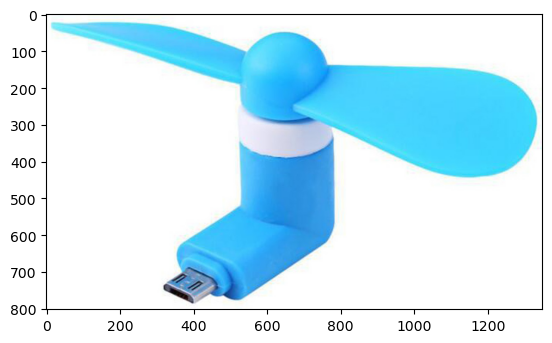

e8ee7868b0c3d1d04b482cd4f3ec5ccc : Prédit "home decor & festive needs" au lieu de "computers" 


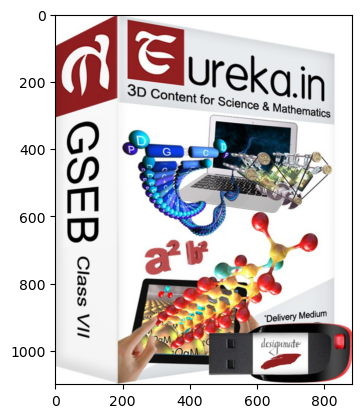

26989e846c2096a5b59b59cbea2cc7ab : Prédit "baby care" au lieu de "computers" 


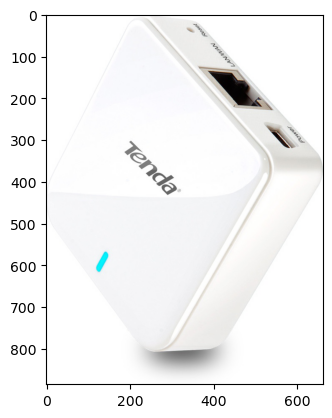

00e966a5049a262cfc72e6bbf68b80e7 : Prédit "baby care" au lieu de "computers" 


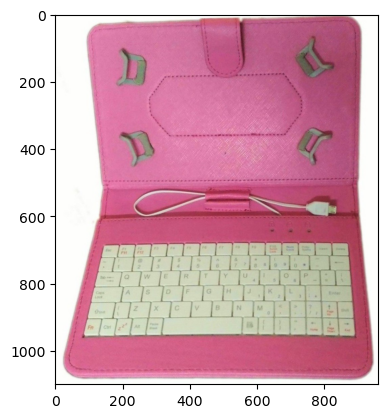

8e961e4fd248c9496ca54808d2d2b25f : Prédit "kitchen & dining" au lieu de "computers" 


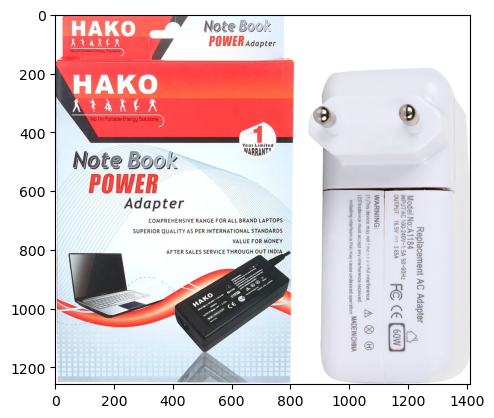

291d5ff1e50dac3058cf10578f692085 : Prédit "kitchen & dining" au lieu de "computers" 


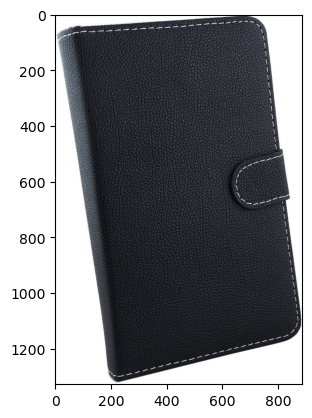

41dccf212ff447cd7213a2b1e669e406 : Prédit "kitchen & dining" au lieu de "computers" 


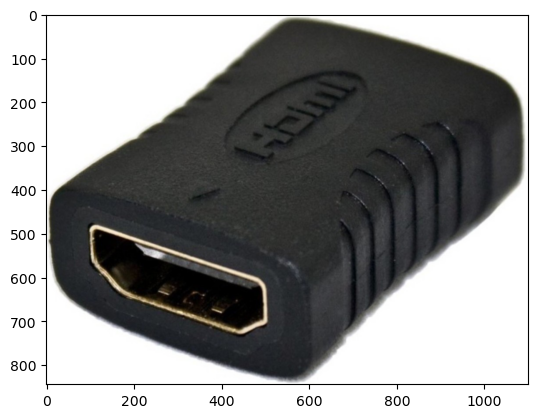

fc009e0b404034e5ea065ba980917f33 : Prédit "baby care" au lieu de "computers" 


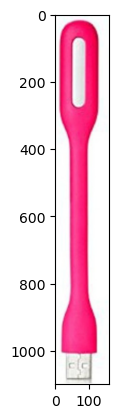

568f331e1039bf2e0635b899c2b3248f : Prédit "baby care" au lieu de "computers" 


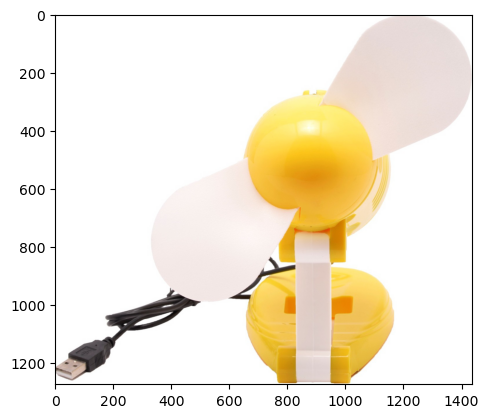

In [37]:

for uniq_id, category, predicted in df_comp.loc[(df_comp["category"]=="computers") & (df_comp["predicted"]!="computers"), ["uniq_id", "category", "predicted"]].values:
    print(f"""{uniq_id} : Prédit "{predicted}" au lieu de "{category}" """)
    img = plt.imread(f'C:/Users/pouri/OneDrive/Bureau/P6/7categ1/test/{sanitize_filename(category)}/{uniq_id}.jpg')
    imgplot = plt.imshow(img)
    plt.show()